<a href="https://colab.research.google.com/github/Rohithb97/DesignOptimization2021Fall/blob/main/Project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[1] loss: 365484.875


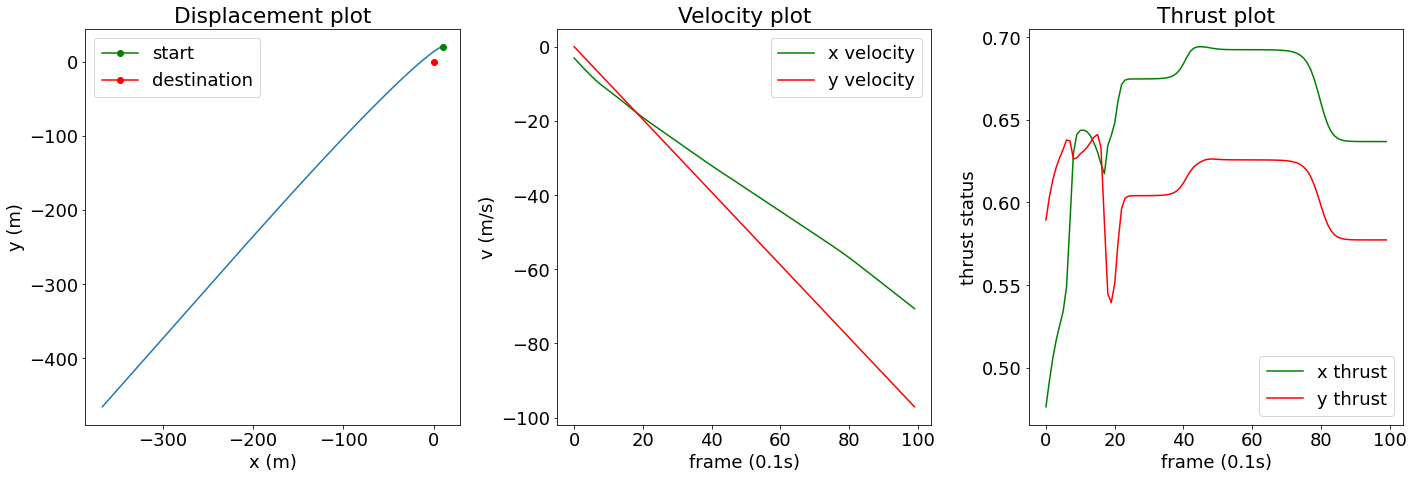

[2] loss: 307313.750
[3] loss: 284001.906
[4] loss: 263037.469
[5] loss: 251451.281
[6] loss: 241620.547
[7] loss: 236090.266
[8] loss: 232225.109
[9] loss: 230496.328
[10] loss: 229417.281
[11] loss: 228740.500


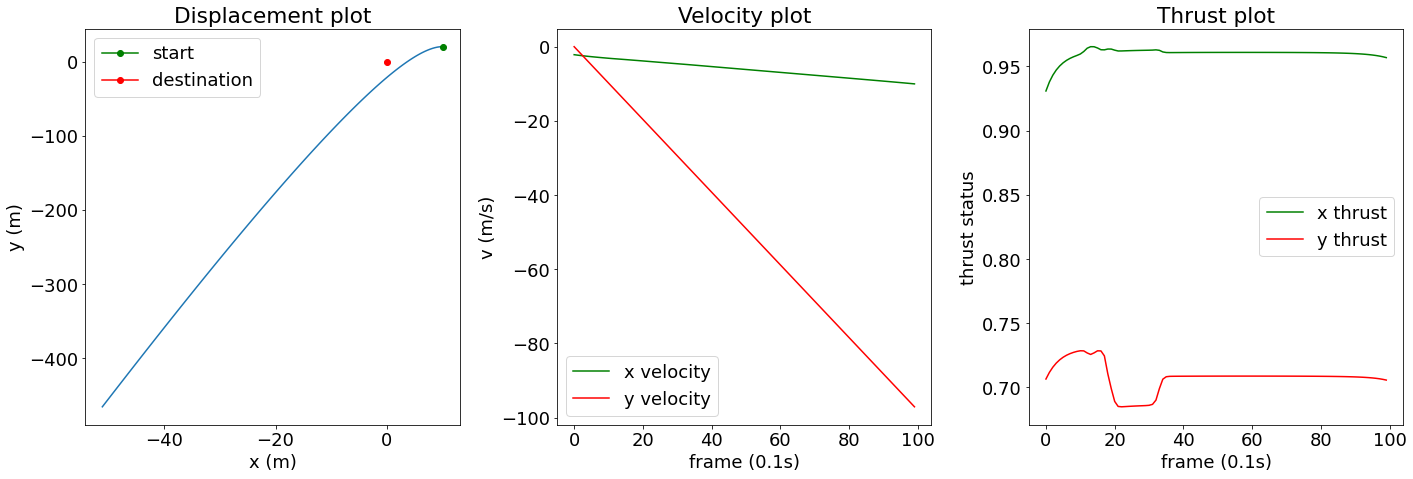

[12] loss: 228248.797
[13] loss: 227845.766
[14] loss: 227516.016
[15] loss: 227263.297
[16] loss: 227041.562
[17] loss: 226773.422
[18] loss: 226569.469
[19] loss: 226457.312
[20] loss: 226386.000
[21] loss: 226335.859


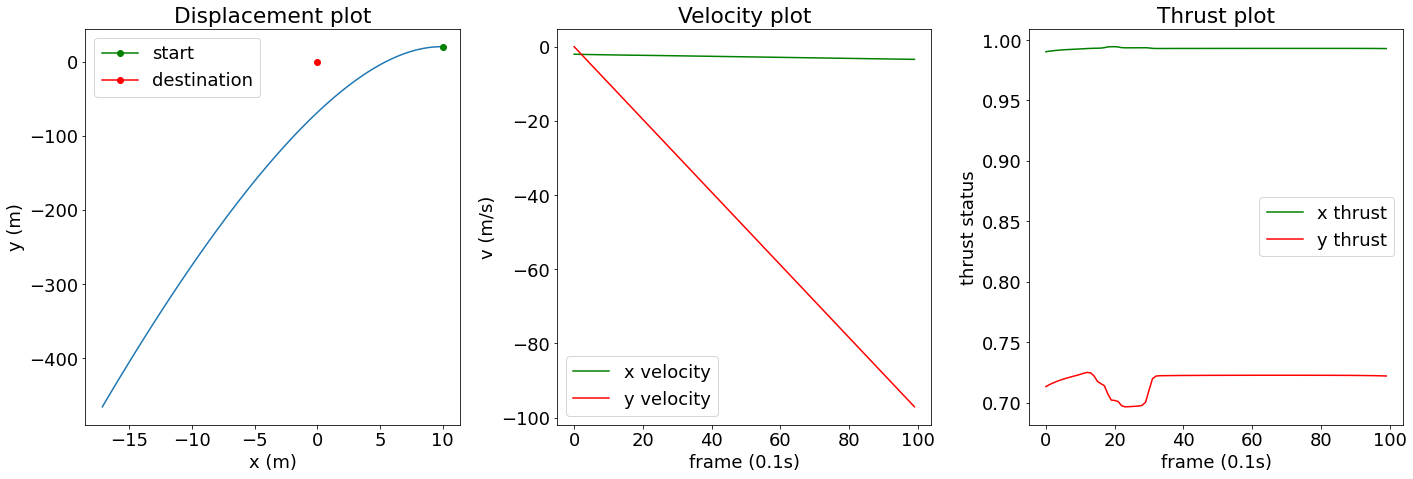

[22] loss: 226256.500
[23] loss: 226213.312
[24] loss: 226195.047
[25] loss: 226181.047
[26] loss: 226173.266
[27] loss: 226164.719
[28] loss: 226152.812
[29] loss: 226148.031
[30] loss: 226144.672
[31] loss: 226140.391


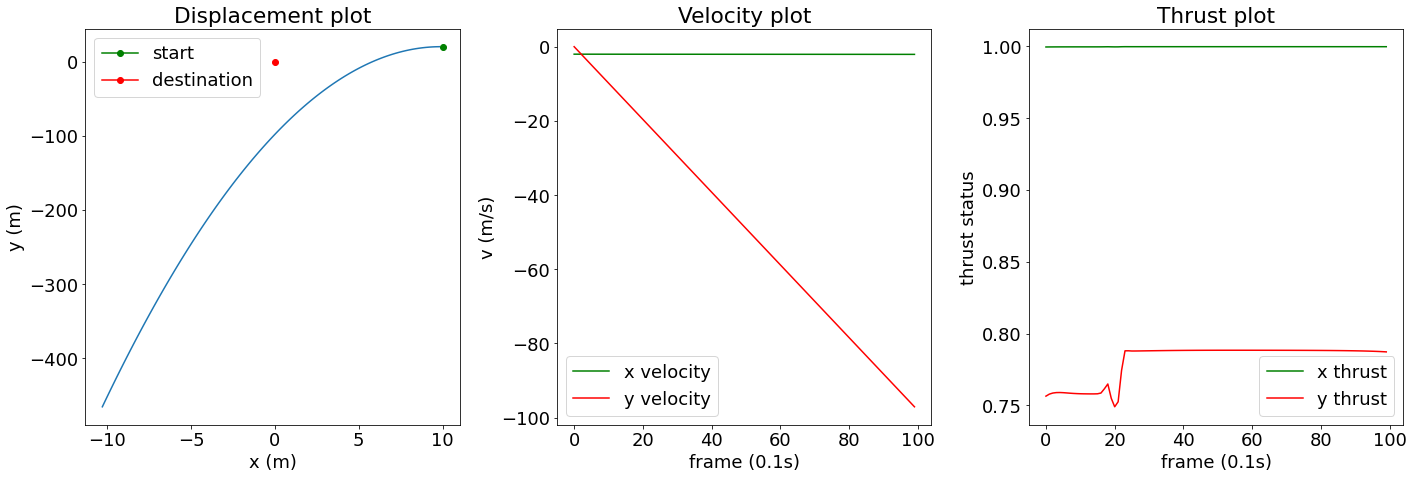

[32] loss: 226138.812
[33] loss: 226137.438
[34] loss: 226136.578
[35] loss: 226136.047
[36] loss: 226135.703
[37] loss: 226135.547
[38] loss: 226135.438
[39] loss: 226135.359
[40] loss: 226135.297
[41] loss: 226135.250


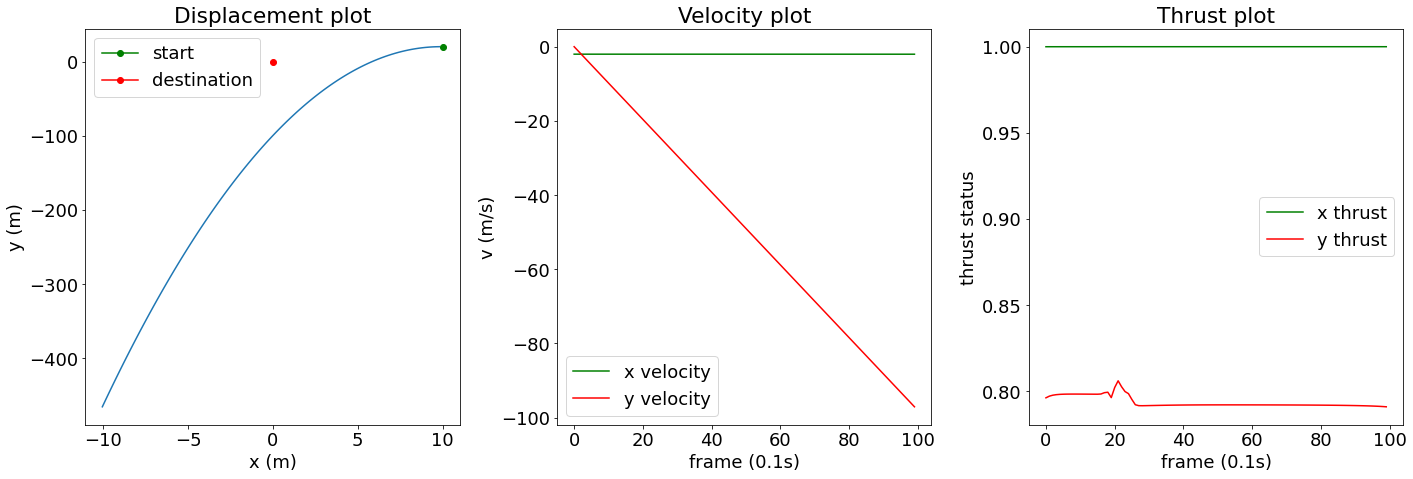

[42] loss: 226135.219
[43] loss: 226135.188
[44] loss: 226135.156
[45] loss: 226135.141
[46] loss: 226135.109
[47] loss: 226135.094
[48] loss: 226135.078
[49] loss: 226135.047
[50] loss: 226134.859
[51] loss: 226134.719


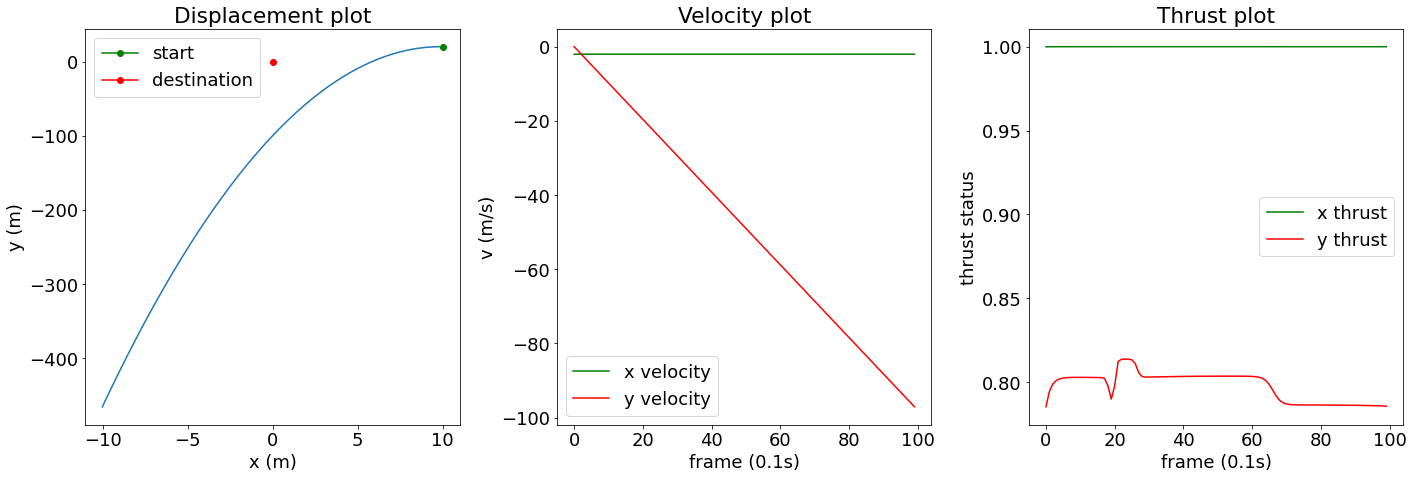

[52] loss: 226134.703
[53] loss: 226134.688
[54] loss: 226134.672
[55] loss: 226134.672
[56] loss: 226134.656
[57] loss: 226134.656
[58] loss: 226134.641
[59] loss: 226134.641
[60] loss: 226134.641
[61] loss: 226134.625


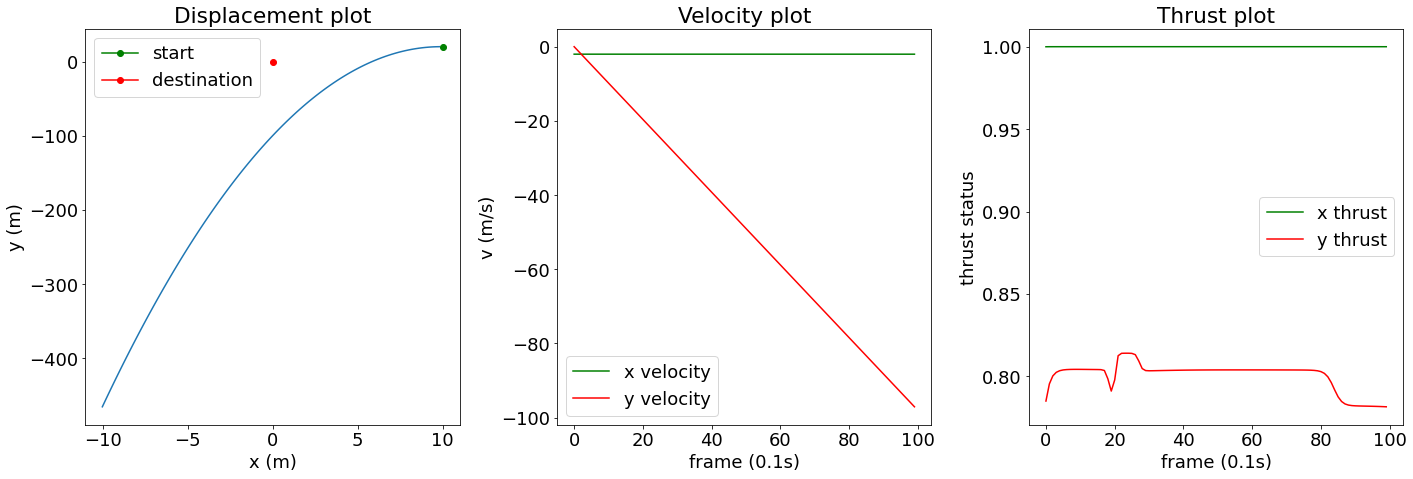

[62] loss: 226134.625
[63] loss: 226134.625
[64] loss: 226134.609
[65] loss: 226134.609
[66] loss: 226134.609
[67] loss: 226134.609
[68] loss: 226134.594
[69] loss: 226134.594
[70] loss: 226134.594
[71] loss: 226134.594


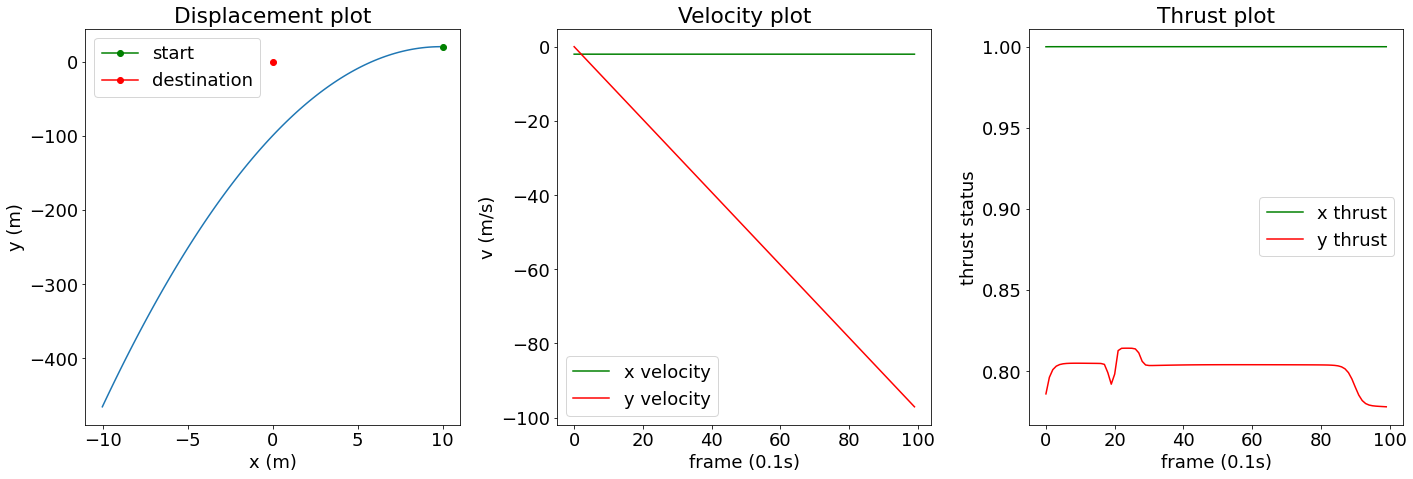

[72] loss: 226134.578
[73] loss: 226134.578
[74] loss: 226134.578
[75] loss: 226134.578
[76] loss: 226134.578
[77] loss: 226134.562
[78] loss: 226134.562
[79] loss: 226134.562
[80] loss: 226134.562
[81] loss: 226134.562


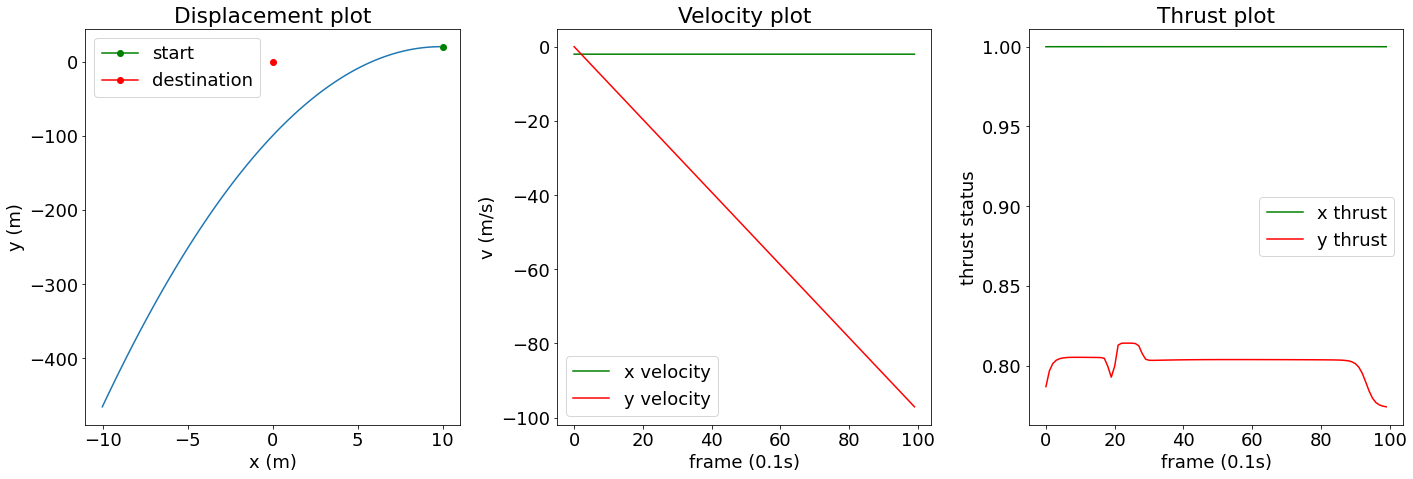

In [11]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt
logger = logging.getLogger(__name__)
plt.rcParams.update({'font.size': 18})
# environment parameters
FRAME_TIME = 0.1  # second, time interval
GRAVITY_ACCEL = 9.81  # m/s2, gravity constant
BOOST_ACCEL = 20.0  # m/s2, thrust constant

# define system dynamics

class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    @staticmethod
    def forward(state, action):

        """
        action:
        action[0]: thrust in x direction. range (0, 1). 
                    1 means max thrust. 0 means no thrust.
        action[1]: thrust in y direction. range (0, 1).
                    0 means thrust to left.
                    0.5 means no thrust.
                    1 means thrust to right.
        
        states:
        state[0] = x
        state[1] = v_x
        state[2] = y
        state[3] = v_y
        """
        
        # Apply gravity       
        delta_state_gravity = -t.tensor([0., 0., 0., GRAVITY_ACCEL * FRAME_TIME])

        # Thrust of x and y directions are calculated respectively
        thrust_x = action[0]*2.0-1.0
        thrust_y = action[1]
        delta_state_x = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 1.0 , 0., 0.]) * thrust_x
        delta_state_y = BOOST_ACCEL * FRAME_TIME * t.tensor([0., 0. , 0., 1.0]) * thrust_y
        temp = delta_state_y
        
        """"
        The calculation and assumptions of specifiactions of rocket is as shown below
        
        Drag force: D = Cd * A * .5 * r * V^2
        Cd = 0.3 (Drag co-efficint of cylinder) ref: 
        A = pi * 9 ^2 = 254.47 m^2
        r = 400 kg/m^3 (Density of material)
        V = velocity = delta state
        m = 600000 Kg 
        
        D = 0.3 * 254.47 * 0.5 * 400 * delta_state**2
        
        also applying force balance on the rocket
        
        m * DRAG_DECEL (deceleration due to drag) = D
        DRAG_DECEL = 0.02545 * delta_state**2
        
        """
        #Updating drag
        DRAG_DECEL = 0.02545 * temp* temp
        
        NET_ACCEL = BOOST_ACCEL - DRAG_DECEL # Updating net accel in Y
        
        #Re-calculating new velocity in Y
        delta_state_y = NET_ACCEL * FRAME_TIME * t.tensor([0., -1., 0., 0.]) * action[0]
        
        # Update velocity, both gravity, thrust of x and y are used
        state = state + delta_state_x + delta_state_y + delta_state_gravity
        
        # Update state 
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                            [0., 1., 0., 0.],
                            [0., 0., 1., FRAME_TIME],
                            [0., 0., 0., 1.]])
        state = t.matmul(step_mat, state)

        return state

# a deterministic controller

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),#
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

# the simulator that rolls out x(1), x(2), ..., x(T)

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        # initial position of the rocket is set at (10, 20) with zero initial velocity
        state = [10.0, -2.0, 20.0, 1.0]  
        return t.tensor(state, requires_grad=False).float()

    # calculation of the loss function
    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2

# set up the optimizer

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.008)

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            return loss
        self.optimizer.step(closure)
        return closure()
    
    def train(self, epochs):
        for epoch in range(epochs):
            loss = self.step()
            print('[%d] loss: %.3f' % (epoch + 1, loss))
            if epoch % 10 == 0:
                self.visualize()

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x1 = data[:, 0]
        v_x = data[:, 1]
        y1 = data[:, 2]
        v_y = data[:, 3]
        tt = range(self.simulation.T)
        data1 = np.array([self.simulation.action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        thrust_xx = data1[:, 0]
        thrust_yy = data1[:, 1]
        
        fig, ax = plt.subplots(1, 3, figsize=(20, 7))
        
        ax[0].plot(x1, y1)
        ax[0].plot(10, 20, '-ro', c='g', label='start')
        ax[0].plot(0, 0, '-ro', c='r', label='destination')
        ax[0].set_xlabel('x (m)')
        ax[0].set_ylabel('y (m)')
        ax[0].set(title='Displacement plot')
        ax[0].legend()
        
        ax[1].plot(tt, v_x, c='g', label='x velocity')
        ax[1].plot(tt, v_y, c='r', label='y velocity')
        ax[1].set_xlabel('frame (0.1s)')
        ax[1].set_ylabel('v (m/s)')
        ax[1].set(title='Velocity plot')
        ax[1].legend()
        
        ax[2].plot(tt, thrust_xx, c='g', label='x thrust')
        ax[2].plot(tt, thrust_yy, c='r', label='y thrust')
        ax[2].set_xlabel('frame (0.1s)')
        ax[2].set_ylabel('thrust status')
        ax[2].set(title='Thrust plot')
        ax[2].legend()
           
        fig.tight_layout()
        
        plt.show()

# Now it's time to run the code!
T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 10  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(81)  # solve the optimization problem